In [1]:
# 📦 라이브러리 불러오기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# 📁 데이터 불러오기
df = pd.read_parquet('prepro_data.parquet')
df1 = df[df['호선'] == 2].copy()
cols = ['연도', '호선','상하구분','AWS지점코드']
for col in cols:
    df1[col] = df1[col].astype('category')

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15187582 entries, 0 to 15653609
Data columns (total 25 columns):
 #   Column    Dtype         
---  ------    -----         
 0   시간        datetime64[ns]
 1   호선        int64         
 2   역번호       int32         
 3   역명        category      
 4   상하구분      category      
 5   AWS지점코드   int64         
 6   기온        float32       
 7   풍향        float32       
 8   풍속        float32       
 9   일강수량      float32       
 10  시간강수량     float32       
 11  상대습도      float32       
 12  체감온도      float32       
 13  혼잡도       float32       
 14  승차총승객수    float32       
 15  하차총승객수    float32       
 16  미세먼지      float32       
 17  연도        int32         
 18  월         int32         
 19  일         int32         
 20  시         int32         
 21  요일        int32         
 22  주말        int32         
 23  공휴일       int32         
 24  일사량_측정여부  int32         
dtypes: category(2), datetime64[ns](1), float32(11), int32(9), int64(2)
memory u

In [3]:
# 시 (0~23 기준)
df1['시_sin'] = np.sin(2 * np.pi * df1['시'] / 24)
df1['시_cos'] = np.cos(2 * np.pi * df1['시'] / 24)

# 요일 (0~6 기준, 월~일)
df1['요일_sin'] = np.sin(2 * np.pi * df1['요일'] / 7)
df1['요일_cos'] = np.cos(2 * np.pi * df1['요일'] / 7)

# 월, 일 (1~12, 1~31 기준)
le = LabelEncoder()
df['월'] = le.fit_transform(df['월'])
df['일'] = le.fit_transform(df['일'])

# 1. float64 → float32
float_cols = df1.select_dtypes(include=['float64']).columns
df1[float_cols] = df1[float_cols].astype('float32')

# 2. int64 → int32
int_cols = df1.select_dtypes(include=['int64']).columns
df1[int_cols] = df1[int_cols].astype('int32')

# 3. object(문자열) → category
obj_cols = df1.select_dtypes(include=['object']).columns
df1[obj_cols] = df1[obj_cols].astype('category')    
    
df1 = df1.drop(['시', '요일'], axis=1)
df1.info()

# ✅ [1] 피처 구성 및 전처리 --------------------------------------------------------

# 🎯 타겟 변수 '혼잡도' 제거하여 X 생성
X = df1.drop(['혼잡도', '시간'], axis=1)

# 🔤 범주형 변수 원-핫 인코딩 (첫 번째 카테고리는 drop)
o_h_e_x = pd.get_dummies(X, columns=['연도', '역명', '호선', '상하구분', 'AWS지점코드'], drop_first=True)

<class 'pandas.core.frame.DataFrame'>
Index: 1868722 entries, 950460 to 12006245
Data columns (total 27 columns):
 #   Column    Dtype         
---  ------    -----         
 0   시간        datetime64[ns]
 1   호선        category      
 2   역번호       int32         
 3   역명        category      
 4   상하구분      category      
 5   AWS지점코드   category      
 6   기온        float32       
 7   풍향        float32       
 8   풍속        float32       
 9   일강수량      float32       
 10  시간강수량     float32       
 11  상대습도      float32       
 12  체감온도      float32       
 13  혼잡도       float32       
 14  승차총승객수    float32       
 15  하차총승객수    float32       
 16  미세먼지      float32       
 17  연도        category      
 18  월         int32         
 19  일         int32         
 20  주말        int32         
 21  공휴일       int32         
 22  일사량_측정여부  int32         
 23  시_sin     float32       
 24  시_cos     float32       
 25  요일_sin    float32       
 26  요일_cos    float32       
dtypes: category

In [4]:
# 🔢 X 정규화 (0~1 범위로 스케일링)
mm = MinMaxScaler()
mm_x = mm.fit_transform(o_h_e_x)

# 🎯 y 정규화 (표준화: 평균 0, 표준편차 1)
y = df1[['혼잡도']]  # 2D로 유지
ss = StandardScaler()
ss_y = ss.fit_transform(y)

In [5]:
# ✅ [2] 시계열 학습/검증 데이터 분할 --------------------------------------------------

# 전체의 80%를 학습용, 나머지 20%를 검증용으로 사용
split_index = int(len(mm_x) * 0.8)

train_x = mm_x[:split_index]
train_y = ss_y[:split_index]

val_x = mm_x[split_index:]
val_y = ss_y[split_index:]

# (1) GRU 적용 : batch_size = 32

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dropout, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# ✅ ModelCheckpoint 콜백 추가 ---------------------------------------
checkpoint = ModelCheckpoint(
    filepath='best_model_GRU_32.h5',         # 저장할 모델 파일명
    monitor='val_loss',                       # 검증 손실 기준
    save_best_only=True,                      # 가장 성능 좋은 모델만 저장
    save_weights_only=False,                  # 전체 모델 저장 (구조 + 가중치)
    verbose=1                                 # 저장될 때마다 메시지 출력
)

# 시계열 생성기 설정
sequence_length = 21
batch_size = 32

train_gen = TimeseriesGenerator(train_x, train_y, length=sequence_length, batch_size=batch_size)
val_gen   = TimeseriesGenerator(val_x, val_y, length=sequence_length, batch_size=batch_size)

# ✅ GRU 기반 모델 정의 --------------------------------------------------------
model1 = Sequential([
    Input(shape=(sequence_length, train_x.shape[1])),
    GRU(64, return_sequences=True),
    Dropout(0.2),
    GRU(32),
    Dropout(0.2),
    Dense(1)
])

# 모델 컴파일
model1.compile(loss='mse', optimizer=Adam(0.001))

# 콜백 설정
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5)

# 모델 학습
history1 = model1.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=[early_stop,  reduce_lr, checkpoint]
    # 필요 시 early_stop 추가: callbacks=[early_stop, reduce_lr, checkpoint]
)

Epoch 1/50
46716/46718 [============================>.] - ETA: 0s - loss: 0.1334
Epoch 1: val_loss improved from inf to 0.10486, saving model to best_model_GRU_32.h5
46718/46718 [==============================] - 785s 17ms/step - loss: 0.1334 - val_loss: 0.1049 - lr: 0.0010
Epoch 2/50
46718/46718 [==============================] - ETA: 0s - loss: 0.0722
Epoch 2: val_loss improved from 0.10486 to 0.07600, saving model to best_model_GRU_32.h5
46718/46718 [==============================] - 810s 17ms/step - loss: 0.0722 - val_loss: 0.0760 - lr: 0.0010
Epoch 3/50
46718/46718 [==============================] - ETA: 0s - loss: 0.0622
Epoch 3: val_loss did not improve from 0.07600
46718/46718 [==============================] - 831s 18ms/step - loss: 0.0622 - val_loss: 0.0816 - lr: 0.0010
Epoch 4/50
46717/46718 [============================>.] - ETA: 0s - loss: 0.0573
Epoch 4: val_loss improved from 0.07600 to 0.07502, saving model to best_model_GRU_32.h5
46718/46718 [==========================

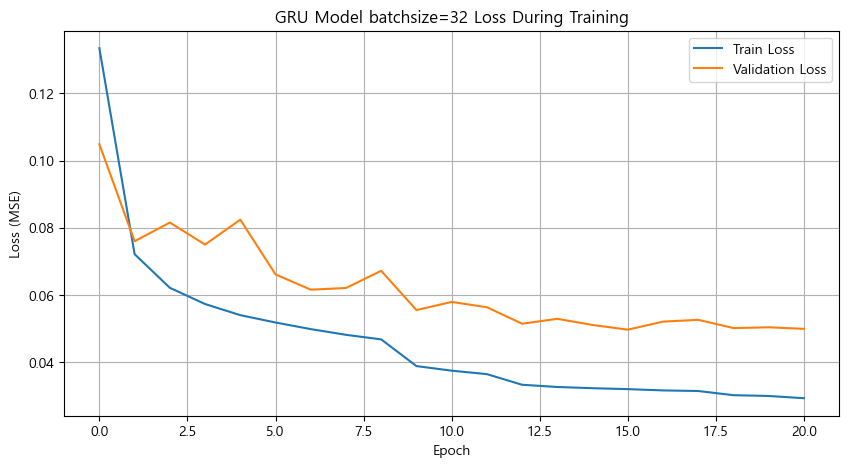

In [17]:
# 📊 학습 및 검증 손실 시각화
plt.rcParams['font.family']='Malgun Gothic'
plt.figure(figsize=(10, 5))
plt.plot(history1.history['loss'], label='Train Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.title('GRU Model batchsize=32 Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

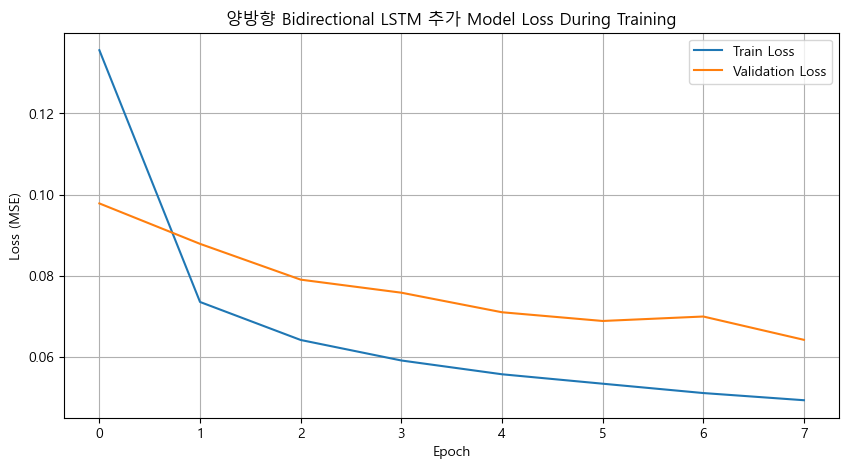
- 30에폭까지 돌린 건데 마지막 부분을 보니 더 학습시켜볼 여지가 있어 5에폭 더 돌림
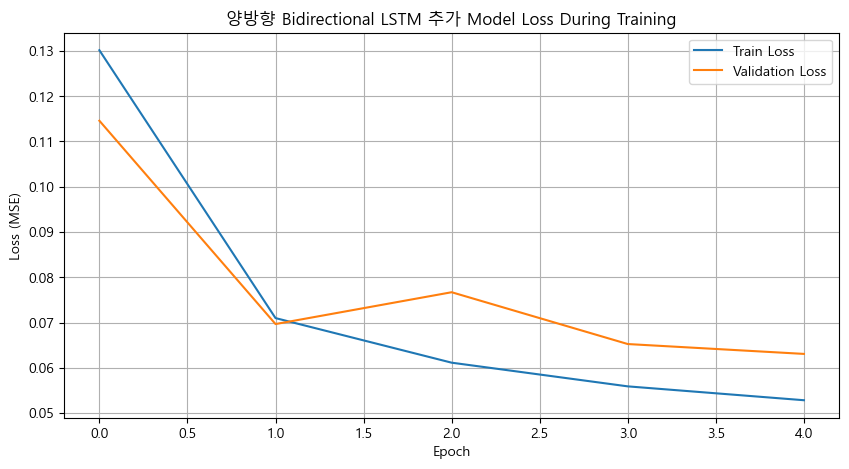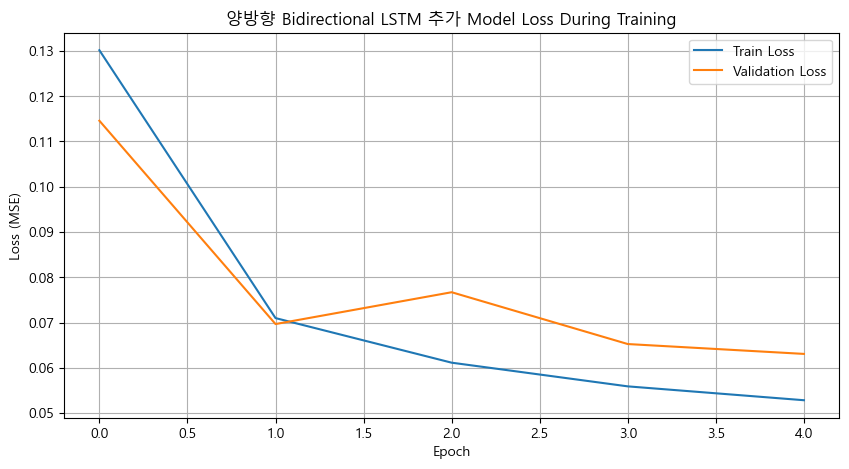
- 또 5에폭 더...

# (2) GRU 적용 : batch_size = 64

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dropout, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# ✅ ModelCheckpoint 콜백 추가 ---------------------------------------
checkpoint = ModelCheckpoint(
    filepath='best_model_GRU_64.h5',         # 저장할 모델 파일명
    monitor='val_loss',                       # 검증 손실 기준
    save_best_only=True,                      # 가장 성능 좋은 모델만 저장
    save_weights_only=False,                  # 전체 모델 저장 (구조 + 가중치)
    verbose=1                                 # 저장될 때마다 메시지 출력
)

# 시계열 생성기 설정
sequence_length = 21
batch_size = 64

train_gen = TimeseriesGenerator(train_x, train_y, length=sequence_length, batch_size=batch_size)
val_gen   = TimeseriesGenerator(val_x, val_y, length=sequence_length, batch_size=batch_size)

# ✅ GRU 기반 모델 정의 --------------------------------------------------------
model2 = Sequential([
    Input(shape=(sequence_length, train_x.shape[1])),
    GRU(64, return_sequences=True),
    Dropout(0.2),
    GRU(32),
    Dropout(0.2),
    Dense(1)
])

# 모델 컴파일
model2.compile(loss='mse', optimizer=Adam(0.001))

# 콜백 설정
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5)

# 모델 학습
history2 = model2.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=[reduce_lr, checkpoint, early_stop]
    # 필요 시 early_stop 추가: callbacks=[early_stop, reduce_lr, checkpoint]
)

Epoch 1/50
23358/23359 [============================>.] - ETA: 0s - loss: 0.1622
Epoch 1: val_loss improved from inf to 0.10899, saving model to best_model_GRU_64.h5
23359/23359 [==============================] - 506s 22ms/step - loss: 0.1622 - val_loss: 0.1090 - lr: 0.0010
Epoch 2/50
23359/23359 [==============================] - ETA: 0s - loss: 0.0832
Epoch 2: val_loss improved from 0.10899 to 0.09502, saving model to best_model_GRU_64.h5
23359/23359 [==============================] - 504s 22ms/step - loss: 0.0832 - val_loss: 0.0950 - lr: 0.0010
Epoch 3/50
23357/23359 [============================>.] - ETA: 0s - loss: 0.0698
Epoch 3: val_loss improved from 0.09502 to 0.07837, saving model to best_model_GRU_64.h5
23359/23359 [==============================] - 505s 22ms/step - loss: 0.0698 - val_loss: 0.0784 - lr: 0.0010
Epoch 4/50
23358/23359 [============================>.] - ETA: 0s - loss: 0.0635
Epoch 4: val_loss improved from 0.07837 to 0.07098, saving model to best_model_GRU_64.

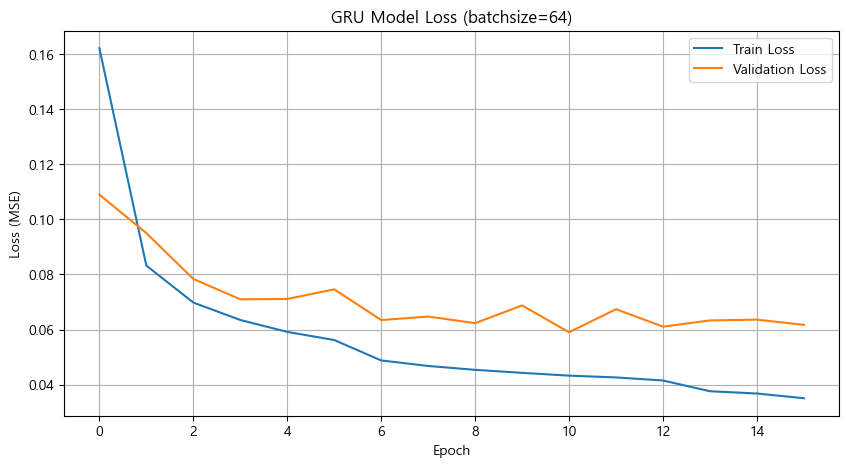

In [19]:
# 📊 학습 및 검증 손실 시각화
plt.rcParams['font.family']='Malgun Gothic'
plt.figure(figsize=(10, 5))
plt.plot(history2.history['loss'], label='Train Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.title('GRU Model Loss (batchsize=64)')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

# (3) GRU 적용 : batch_size = 128

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dropout, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# ✅ ModelCheckpoint 콜백 추가 ---------------------------------------
checkpoint = ModelCheckpoint(
    filepath='best_model_GRU_128.h5',         # 저장할 모델 파일명
    monitor='val_loss',                       # 검증 손실 기준
    save_best_only=True,                      # 가장 성능 좋은 모델만 저장
    save_weights_only=False,                  # 전체 모델 저장 (구조 + 가중치)
    verbose=1                                 # 저장될 때마다 메시지 출력
)

# 시계열 생성기 설정
sequence_length = 21
batch_size = 128

train_gen = TimeseriesGenerator(train_x, train_y, length=sequence_length, batch_size=batch_size)
val_gen   = TimeseriesGenerator(val_x, val_y, length=sequence_length, batch_size=batch_size)

# ✅ GRU 기반 모델 정의 --------------------------------------------------------
model3 = Sequential([
    Input(shape=(sequence_length, train_x.shape[1])),
    GRU(64, return_sequences=True),
    Dropout(0.2),
    GRU(32),
    Dropout(0.2),
    Dense(1)
])

# 모델 컴파일
model3.compile(loss='mse', optimizer=Adam(0.001))

# 콜백 설정
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5)

# 모델 학습
history3 = model3.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    callbacks=[reduce_lr, checkpoint]
    # 필요 시 early_stop 추가: callbacks=[early_stop, reduce_lr, checkpoint]
)

In [ ]:
# 📊 학습 및 검증 손실 시각화
plt.rcParams['font.family']='Malgun Gothic'
plt.figure(figsize=(10, 5))
plt.plot(history3.history['loss'], label='Train Loss')
plt.plot(history3.history['val_loss'], label='Validation Loss')
plt.title('GRU Model Loss (batchsize=128)')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

# (4) GRU 적용 : batch_size = 256

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dropout, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# ✅ ModelCheckpoint 콜백 추가 ---------------------------------------
checkpoint = ModelCheckpoint(
    filepath='best_model_GRU_256.h5',         # 저장할 모델 파일명
    monitor='val_loss',                       # 검증 손실 기준
    save_best_only=True,                      # 가장 성능 좋은 모델만 저장
    save_weights_only=False,                  # 전체 모델 저장 (구조 + 가중치)
    verbose=1                                 # 저장될 때마다 메시지 출력
)

# 시계열 생성기 설정
sequence_length = 21
batch_size = 256

train_gen = TimeseriesGenerator(train_x, train_y, length=sequence_length, batch_size=batch_size)
val_gen   = TimeseriesGenerator(val_x, val_y, length=sequence_length, batch_size=batch_size)

# ✅ GRU 기반 모델 정의 --------------------------------------------------------
model4 = Sequential([
    Input(shape=(sequence_length, train_x.shape[1])),
    GRU(64, return_sequences=True),
    Dropout(0.2),
    GRU(32),
    Dropout(0.2),
    Dense(1)
])

# 모델 컴파일
model4.compile(loss='mse', optimizer=Adam(0.001))

# 콜백 설정
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5)

# 모델 학습
history4 = model4.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    callbacks=[reduce_lr, checkpoint, early_stop]
    # 필요 시 early_stop 추가: callbacks=[early_stop, reduce_lr, checkpoint]
)

Epoch 1/30
5839/5840 [============================>.] - ETA: 0s - loss: 0.2628
Epoch 1: val_loss improved from inf to 0.18380, saving model to best_model_GRU_256.h5
5840/5840 [==============================] - 262s 44ms/step - loss: 0.2628 - val_loss: 0.1838 - lr: 0.0010
Epoch 2/30
5840/5840 [==============================] - ETA: 0s - loss: 0.1169
Epoch 2: val_loss improved from 0.18380 to 0.12470, saving model to best_model_GRU_256.h5
5840/5840 [==============================] - 264s 45ms/step - loss: 0.1169 - val_loss: 0.1247 - lr: 0.0010
Epoch 3/30
5839/5840 [============================>.] - ETA: 0s - loss: 0.0986
Epoch 3: val_loss improved from 0.12470 to 0.12318, saving model to best_model_GRU_256.h5
5840/5840 [==============================] - 264s 45ms/step - loss: 0.0986 - val_loss: 0.1232 - lr: 0.0010
Epoch 4/30
5840/5840 [==============================] - ETA: 0s - loss: 0.0871
Epoch 4: val_loss improved from 0.12318 to 0.08709, saving model to best_model_GRU_256.h5
5840/58

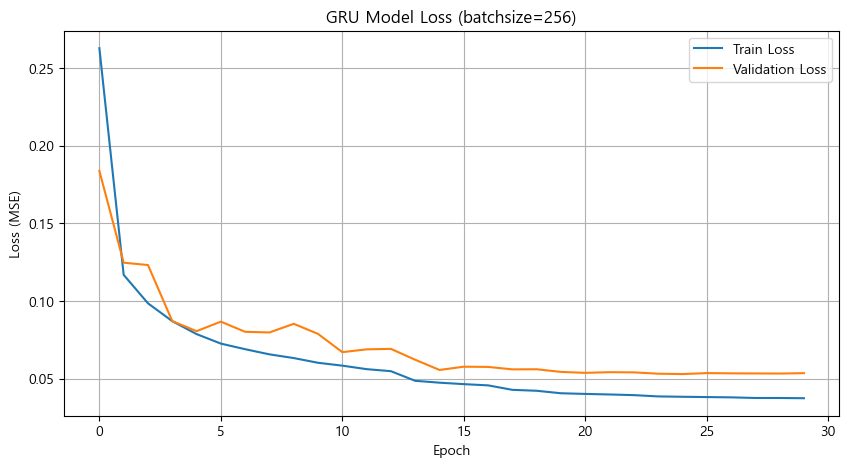

In [22]:
# 📊 학습 및 검증 손실 시각화
plt.rcParams['font.family']='Malgun Gothic'
plt.figure(figsize=(10, 5))
plt.plot(history4.history['loss'], label='Train Loss')
plt.plot(history4.history['val_loss'], label='Validation Loss')
plt.title('GRU Model Loss (batchsize=256)')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

# 모델 비교

In [23]:
# ✅ [5] 예측 및 평가 ---------------------------------------------------------------
from tensorflow.keras.models import load_model
loaded_model_1 = load_model('best_model_GRU_32.h5')
loaded_model_2 = load_model('best_model_GRU_64.h5')
# loaded_model_3 = load_model('best_model_GRU_128.h5')
loaded_model_4 = load_model('best_model_GRU_256.h5')

# 검증셋에 대해 예측 수행
pred_scaled_1 = loaded_model_1.predict(val_gen)
pred_scaled_2 = loaded_model_2.predict(val_gen)
# pred_scaled_3 = loaded_model_3.predict(val_gen)
pred_scaled_4 = loaded_model_4.predict(val_gen)

# 정규화 해제 (역정규화) → 실제 혼잡도 단위로 복원
pred_1 = ss.inverse_transform(pred_scaled_1)
pred_2 = ss.inverse_transform(pred_scaled_2)
# pred_3 = ss.inverse_transform(pred_scaled_3)
pred_4 = ss.inverse_transform(pred_scaled_4)

# 실제 y도 시계열 슬라이싱 기준에 맞게 자르기
true = ss.inverse_transform(val_y[sequence_length:])

1460/1460 [==============================] - 31s 21ms/step


In [24]:
# 평가 지표 계산
rmse_1 = mean_squared_error(true, pred_1, squared=False)  # RMSE
r2_1 = r2_score(true, pred_1)                             # R² Score
rmse_2 = mean_squared_error(true, pred_2, squared=False)  # RMSE
r2_2 = r2_score(true, pred_2)                             # R² Score
# rmse_3 = mean_squared_error(true, pred_3, squared=False)  # RMSE
# r2_3 = r2_score(true, pred_3)                             # R² Score
rmse_4 = mean_squared_error(true, pred_4, squared=False)  # RMSE
r2_4 = r2_score(true, pred_4)                             # R² Score

# 결과 출력
print('✅GRU 적용 : batch_size = 32')
print(f" 검증 RMSE: {rmse_1:.4f}")
print(f" R² Score: {r2_1:.4f}")
print()
print('✅GRU 적용 : batch_size = 64')
print(f" 검증 RMSE: {rmse_2:.4f}")
print(f" R² Score: {r2_2:.4f}")
print()
#print('✅GRU 적용 : batch_size = 128')
# print(f" 검증 RMSE: {rmse_3:.4f}")
# print(f" R² Score: {r2_3:.4f}")
# print()
print('✅GRU 적용 : batch_size = 256')
print(f" 검증 RMSE: {rmse_4:.4f}")
print(f" R² Score: {r2_4:.4f}")

✅GRU 적용 : batch_size = 32
 검증 RMSE: 4.5340
 R² Score: 0.9633

✅GRU 적용 : batch_size = 64
 검증 RMSE: 4.9402
 R² Score: 0.9565

✅GRU 적용 : batch_size = 256
 검증 RMSE: 4.6810
 R² Score: 0.9609


C:\Users\campus4D035\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\campus4D035\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\campus4D035\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Epoch 23: val_loss improved from 0.03989 to 0.03952, saving model to best_model_batchsize_32.h5  
Epoch 15: val_loss improved from 0.05258 to 0.05148, saving model to best_model_batchsize_64.h5  
Epoch 19: val_loss improved from 0.05784 to 0.05711, saving model to best_model_batchsize_128.h5  
Epoch 29: val_loss improved from 0.05363 to 0.05326, saving model to best_model_batchsize_256.h5

In [ ]:
# ✅ 🔍 예측 vs 실제 시각화 ---------------------------------------------------------

df_pred = df1.iloc[split_index + sequence_length:].copy()
df_pred['predicted_congestion'] = pred
df_pred['true_congestion'] = true

df_pred[['시간', 'true_congestion', 'predicted_congestion']].set_index('시간').plot(figsize=(15, 5))
plt.title('혼잡도 예측 vs 실제')
plt.grid(True)
plt.show()


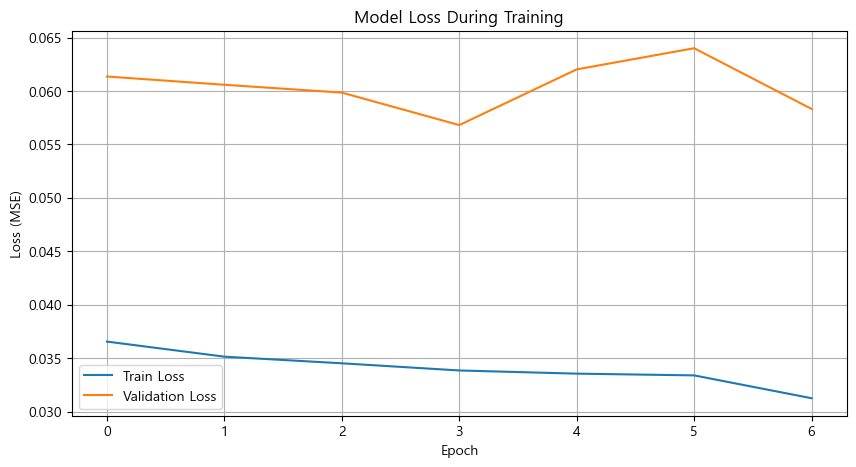

In [17]:
# 📊 학습 및 검증 손실 시각화
plt.figure(figsize=(10, 5))
plt.plot(history_additional.history['loss'], label='Train Loss')
plt.plot(history_additional.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

- 6번 더 학습하니 살짝 개선
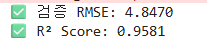
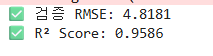

In [19]:
# 추가 학습: 이어서 계속 학습
# epochs=16~30까지 추가로 학습하려면 epochs=16을 지정하면 됩니다.
history_additional = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,                 # 총 학습 epoch. 이미 14번 했으므로 여기선 15~30까지 실행됨
    initial_epoch=21,         # 14번째까지 학습했다면 여기서 이어서 시작
    callbacks=[early_stop, reduce_lr]
)

Epoch 22/30
11680/11680 [==============================] - 504s 43ms/step - loss: 0.0320 - val_loss: 0.0583 - lr: 2.5000e-04
Epoch 23/30
11680/11680 [==============================] - 511s 44ms/step - loss: 0.0317 - val_loss: 0.0583 - lr: 2.5000e-04
Epoch 24/30
11680/11680 [==============================] - 576s 49ms/step - loss: 0.0313 - val_loss: 0.0598 - lr: 2.5000e-04
Epoch 25/30
11680/11680 [==============================] - 484s 41ms/step - loss: 0.0304 - val_loss: 0.0582 - lr: 1.2500e-04
Epoch 26/30
11680/11680 [==============================] - 541s 46ms/step - loss: 0.0303 - val_loss: 0.0561 - lr: 1.2500e-04
Epoch 27/30
11680/11680 [==============================] - 517s 44ms/step - loss: 0.0301 - val_loss: 0.0570 - lr: 1.2500e-04
Epoch 28/30
11680/11680 [==============================] - 525s 45ms/step - loss: 0.0300 - val_loss: 0.0583 - lr: 1.2500e-04
Epoch 29/30
11680/11680 [==============================] - 502s 43ms/step - loss: 0.0297 - val_loss: 0.0580 - lr: 6.2500e-05


2920/2920 [==============================] - 57s 19ms/step


C:\Users\campus4D035\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


✅ 검증 RMSE: 4.8181
✅ R² Score: 0.9586


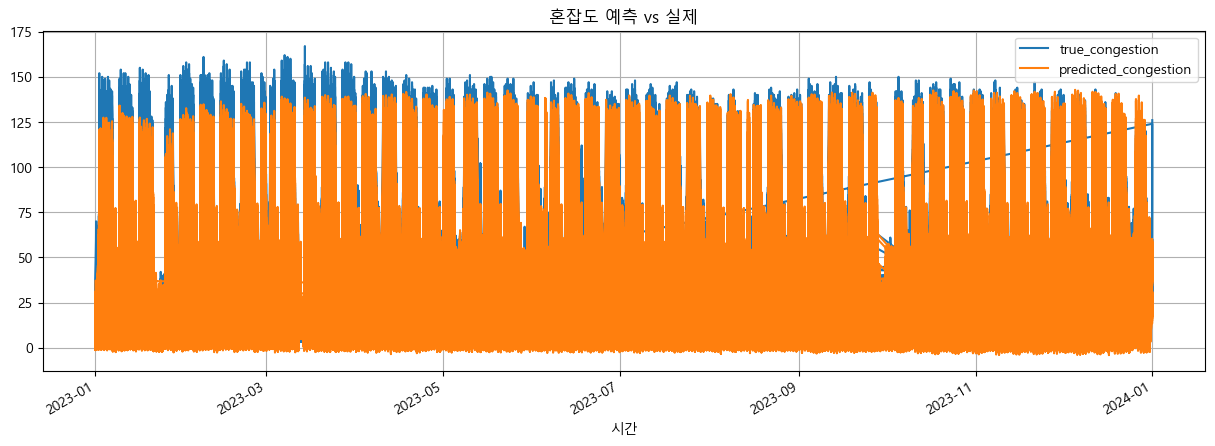

In [20]:
# ✅ [5] 예측 및 평가 ---------------------------------------------------------------

# 검증셋에 대해 예측 수행
pred_scaled = model.predict(val_gen)

# 정규화 해제 (역정규화) → 실제 혼잡도 단위로 복원
pred = ss.inverse_transform(pred_scaled)

# 실제 y도 시계열 슬라이싱 기준에 맞게 자르기
true = ss.inverse_transform(val_y[sequence_length:])

# 평가 지표 계산
rmse = mean_squared_error(true, pred, squared=False)  # RMSE
r2 = r2_score(true, pred)                             # R² Score

# 결과 출력
print(f"✅ 검증 RMSE: {rmse:.4f}")
print(f"✅ R² Score: {r2:.4f}")

# ✅ 🔍 예측 vs 실제 시각화 ---------------------------------------------------------

df_pred = df1.iloc[split_index + sequence_length:].copy()
df_pred['predicted_congestion'] = pred
df_pred['true_congestion'] = true

df_pred[['시간', 'true_congestion', 'predicted_congestion']].set_index('시간').plot(figsize=(15, 5))
plt.title('혼잡도 예측 vs 실제')
plt.grid(True)
plt.show()

In [16]:
# 추가 학습: 이어서 계속 학습
# epochs=16~30까지 추가로 학습하려면 epochs=16을 지정하면 됩니다.
history_additional = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,                 # 총 학습 epoch. 이미 14번 했으므로 여기선 15~30까지 실행됨
    initial_epoch=14,         # 14번째까지 학습했다면 여기서 이어서 시작
    callbacks=[
        #early_stop, 
        reduce_lr,checkpoint]
)

Epoch 15/30
11680/11680 [==============================] - 418s 36ms/step - loss: 0.0365 - val_loss: 0.0614 - lr: 5.0000e-04
Epoch 16/30
11680/11680 [==============================] - 507s 43ms/step - loss: 0.0351 - val_loss: 0.0606 - lr: 5.0000e-04
Epoch 17/30
11680/11680 [==============================] - 539s 46ms/step - loss: 0.0345 - val_loss: 0.0598 - lr: 5.0000e-04
Epoch 18/30
11680/11680 [==============================] - 526s 45ms/step - loss: 0.0338 - val_loss: 0.0568 - lr: 5.0000e-04
Epoch 19/30
11680/11680 [==============================] - 575s 49ms/step - loss: 0.0335 - val_loss: 0.0620 - lr: 5.0000e-04
Epoch 20/30
11680/11680 [==============================] - 557s 48ms/step - loss: 0.0334 - val_loss: 0.0640 - lr: 5.0000e-04
Epoch 21/30
11680/11680 [==============================] - 582s 50ms/step - loss: 0.0312 - val_loss: 0.0583 - lr: 2.5000e-04
